# Machine learning for Churn prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score,roc_curve, auc
import shap
from shap import TreeExplainer, Explanation

<h2>Read Data</h2>

In [3]:
file_train = '/Users/pd186029/Documents/Pranay/Teradata/Development/full_stck/data_jarvis_data/data_insights_for_researchers/telco_churn/telco_customer_churn_train.csv'
file_score = '/Users/pd186029/Documents/Pranay/Teradata/Development/full_stck/data_jarvis_data/data_insights_for_researchers/telco_churn/telco_customer_churn_score.csv'

In [4]:
df_train = pd.read_csv(file_train,sep=',')
df_train.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [5]:
df_score = pd.read_csv(file_score,sep=',')
df_score.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.75,1
1,9767-FFLEM,Male,0,No,No,38,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,0
2,0639-TSIQW,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,1
3,8456-QDAVC,Male,0,No,No,19,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,0
4,7750-EYXWZ,Female,0,No,No,12,No,No phone service,DSL,No,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.65,743.30,0


In [6]:
print (df_train.shape)
print (df_score.shape)

(7032, 21)
(11, 21)


# Data Preperation

<b>Remove  records with Total charges = 0 </b>

In [26]:
# List of numeric columns
df_train = df_train[df_train['TotalCharges']!=0]

In [27]:
print (df_train.shape)

(7021, 21)


<b>Remove  records with tenure = 0 </b>

In [28]:
df_train = df_train[df_train['tenure']!=0]

In [29]:
print (df_train.shape)

(7021, 21)


<b>Train/Test split</b>

In [30]:
lst_col_x = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


lst_col_y = 'Churn'

In [31]:
dfx = df_train[lst_col_x] 
dfy = df_train[lst_col_y]

test_size = 0.3
        
##random_state=42 (any constant value) will always give the same test train split
dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(dfx, dfy, test_size=test_size, random_state=0)

In [32]:
print ('Train.X, Y..',dfX_train.shape,dfy_train.shape)
print ('Test .X, Y..',dfX_test.shape,dfy_test.shape)


Train.X, Y.. (4914, 19) (4914,)
Test .X, Y.. (2107, 19) (2107,)


# Model training

<b>Creating a pre-processing</b>

In [33]:
# List of non-numeric columns
non_numeric_columns = df_train.select_dtypes(exclude='number').columns
non_numeric_columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [34]:
non_numeric_columns = ['gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']

In [35]:
# List of non-numeric columns
numeric_columns = df_train.select_dtypes(include='number').columns
numeric_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

In [36]:
numeric_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [37]:
# Preprocessing the features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), non_numeric_columns)
    ])

<b>Creating a pipeline</b>

In [38]:
# Creating a pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier())
])


<b>Model Training</b>

In [39]:
# Training the model
pipeline.fit(dfX_train, dfy_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf', RandomForestClassifier())])

# Model prediction and accuracy

In [40]:
# Making predictions
y_pred = pipeline.predict(dfX_test)

In [41]:
# Evaluating the model
accuracy = accuracy_score(dfy_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7854769814902706


<b>Confusion matrix</b>

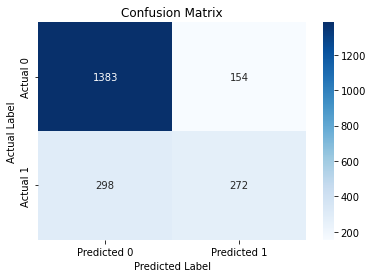

In [42]:
# Create a confusion matrix
conf_matrix = confusion_matrix(dfy_test, y_pred)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

<b>ROC Curve</b>

In [43]:
# Make predictions on the test set
y_pred_prob = pipeline.predict_proba(dfX_test)[:, 1]  # Predicted probabilities for class 1

# Calculate AUC-ROC score
auc_score = roc_auc_score(dfy_test, y_pred_prob)
print ('auc_score..',auc_score)

auc_score.. 0.8293480121905282


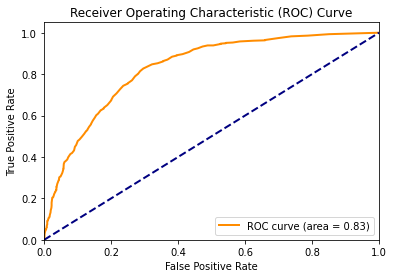

In [44]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(dfy_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Model Explainability

<b>Obtaining the transformed (scaled and one-hot encoded) values and feature names from pipeline</b>

In [123]:
pipeline.named_steps['preprocessor']

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('cat', OneHotEncoder(),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [52]:
dfX_train_transformed = pipeline.named_steps['preprocessor'].transform(dfX_train)
dfX_test_transformed = pipeline.named_steps['preprocessor'].transform(dfX_test)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

In [113]:
feature_names

array(['num__SeniorCitizen', 'num__tenure', 'num__MonthlyCharges',
       'num__TotalCharges', 'cat__gender_Female', 'cat__gender_Male',
       'cat__Partner_No', 'cat__Partner_Yes', 'cat__Dependents_No',
       'cat__Dependents_Yes', 'cat__PhoneService_No',
       'cat__PhoneService_Yes', 'cat__MultipleLines_No',
       'cat__MultipleLines_No phone service', 'cat__MultipleLines_Yes',
       'cat__InternetService_DSL', 'cat__InternetService_Fiber optic',
       'cat__InternetService_No', 'cat__OnlineSecurity_No',
       'cat__OnlineSecurity_No internet service',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_No',
       'cat__OnlineBackup_No internet service', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_No',
       'cat__DeviceProtection_No internet service',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_No',
       'cat__TechSupport_No internet service', 'cat__TechSupport_Yes',
       'cat__StreamingTV_No', 'cat__StreamingTV_No internet service',
       'cat__

<b>Obtaining the model from pipeline</b>

In [71]:
# Initialize the explainer with the training data
clf = pipeline.named_steps['clf']


<b>Creating an explainer based on trained data</b>

In [ ]:
explainer = shap.Explainer(clf, dfX_train_transformed)

<b>Finding the SHAP values using explainer for test data</b>

In [77]:
shap_values = explainer(dfX_test_transformed,check_additivity=False)

100%|===================| 4205/4214 [03:32<00:00]        

<b>Creating explaination using the shap values</b>

In [ ]:
exp = Explanation(shap_values.values[:,:,1], 
                  shap_values.base_values[:,1], 
                  data=dfX_test_transformed, 
                  feature_names=feature_names)

<b>Global explaination</b>

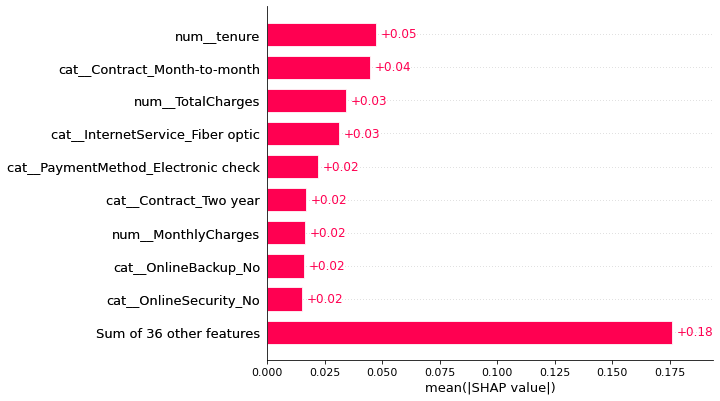

In [112]:
shap.plots.bar(exp)

<b>Local explainer</b>

In [128]:
#Finding record in test data which are predicted to churn
np.where(y_pred_prob > 0.5)[0]

array([   6,    8,   11,   15,   17,   21,   27,   33,   38,   42,   45,
         48,   54,   60,   61,   77,   84,   87,   90,   97,  106,  109,
        126,  132,  143,  147,  162,  175,  176,  178,  187,  191,  192,
        195,  199,  203,  214,  215,  217,  220,  227,  230,  232,  233,
        235,  242,  253,  254,  257,  263,  266,  270,  272,  273,  284,
        286,  293,  299,  300,  304,  306,  313,  319,  320,  322,  325,
        329,  332,  333,  336,  337,  346,  347,  350,  352,  355,  377,
        380,  385,  392,  398,  415,  421,  428,  430,  440,  442,  443,
        451,  458,  463,  465,  469,  472,  474,  480,  482,  491,  500,
        514,  520,  521,  529,  538,  544,  546,  554,  555,  565,  572,
        574,  591,  592,  593,  596,  597,  606,  607,  611,  615,  618,
        620,  622,  626,  637,  639,  641,  644,  645,  646,  660,  664,
        665,  666,  668,  680,  682,  684,  687,  693,  695,  696,  697,
        698,  699,  707,  720,  735,  740,  744,  7

In [129]:
#Probability of churn of a record
idx = 6
y_pred_prob[idx]


0.83

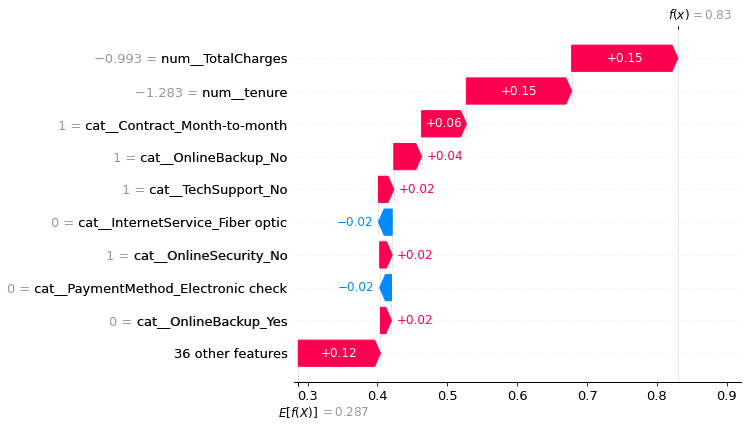

In [130]:
#Explaination of one record
shap.plots.waterfall(exp[idx])